In [2]:
import numpy as np
import math
import os
import pandas as pd
from operator import itemgetter
import pickle
from tqdm import tqdm
import scipy
import random
import yaml

import difflib
import string
import json

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Patch
import seaborn as sns


from sklearn.utils import shuffle

import torch
from torch import Tensor
import datasets
from datasets import load_dataset
from embedding import BertHuggingfaceMLM, BertHuggingface
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from geometrical_bias import SAME, WEAT, GeneralizedWEAT, DirectBias, RIPA, MAC, normalize, cossim, EmbSetList, EmbSet, GeometricBias, cossim
from unmasking_bias import PLLBias

from utils import CLFHead, SimpleCLFHead, CustomModel, JigsawDataset, BiosDataset, DebiasPipeline, upsample_defining_embeddings, WordVectorWrapper
from transformers import AutoModelForMaskedLM, AutoTokenizer
import time

/home/saschroeder/anaconda3/envs/plmbias/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-19 15:33:41.630101: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 15:33:41.666401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 15:33:41.666428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19

In [3]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

In [4]:
titles = ["architect", "psychologist", "professor", "photographer", "journalist", "attorney", "teacher", "dentist", "*software architect", "*writer", "surgeon", "physician", "nurse", "*researcher"]
bios_dataset = BiosDataset(n_folds=5, sel_labels=titles, bios_file="../MeasuringFairnessWithBiasedData/data/BIOS_REVIEWED.pkl")

In [5]:
with open('data/protected_groups.json', 'r') as f:
    pg_config = json.load(f)
    
groups_by_bias_types = pg_config['groups_by_bias_types']
terms_by_groups = pg_config['terms_by_groups']

attributes = [terms_by_groups[group] for group in groups_by_bias_types['gender']]

## Direct Bias PCA dir

In [6]:
texts = [sample['text'] for sample in bios_dataset.sel_data]
y = [sample['label'] for sample in bios_dataset.sel_data]
groups = [sample['group'] for sample in bios_dataset.sel_data]

In [7]:
texts_debiased, _, _ = bios_dataset.get_neutral_samples_by_masking(attributes)

In [8]:
lm = BertHuggingface(model_name='bert-base-uncased', batch_size=8, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


In [9]:
emb = lm.embed(texts)

In [10]:
emb_debiased = lm.embed(texts_debiased)

In [11]:
max_emb = min([groups.count(i) for i in [0,1]])

In [12]:
emb_per_group = [[emb[i] for i in range(len(emb)) if groups[i] == group][:max_emb] for group in range(max(groups)+1)]
debiased_per_group = [[emb_debiased[i] for i in range(len(emb_debiased)) if groups[i] == group][:max_emb] for group in range(max(groups)+1)]

In [13]:
attr_emb = np.asarray([lm.embed(attr) for attr in attributes])
attr_emb.shape

(2, 25, 768)

In [79]:
def fit_and_plot_DB(cur_attr_emb, emb_per_group, k=1, savefile='pca_dir.png'):
    print(cur_attr_emb.shape)
    db = DirectBias(k=k)
    db.define_bias_space(cur_attr_emb)
    b_attr = db.bias_space

    db.define_bias_space(np.asarray(emb_per_group))
    b_bios = db.bias_space
    
    print("explained variance: ", db.pca.explained_variance_ratio_[:10])
    
    if b_attr.shape[0] > 1:
        print(b_attr[0,:].shape)
        print("attr/bios cossim: ", np.sum([cossim(b_attr[i,:].flatten(), b_bios[i,:].flatten()) for i in range(b_attr.shape[0])]))
    else:
        print("attr/bios cossim: ", cossim(b_attr.flatten(), b_bios.flatten()))
    
    n_bias_dir = len(cur_attr_emb[0])+1
    corr = np.eye(n_bias_dir, n_bias_dir)
    for i in range(n_bias_dir-1):
        dir_i = cur_attr_emb[0][i] - cur_attr_emb[1][i]
        for j in range(n_bias_dir-1):
            if j > i:
                continue
            #elif j == i:
            #    corr[i,j] = 1
            else:
                dir_j = cur_attr_emb[0][j] - cur_attr_emb[1][j]
                corr[i,j] = cossim(dir_i, dir_j)
        if b_attr.shape[0] > 1:
            corr[-1,i] = np.sum([cossim(dir_i, b_attr[j,:].flatten()) for j in range(b_attr.shape[0])])
        else:
            corr[-1,i] = cossim(dir_i, b_attr.flatten())
        
        
    sns.heatmap(np.abs(corr))
    plt.savefig(savefile)
    plt.show()
    return corr

(2, 25, 768)
explained variance:  [0.10068305 0.072489   0.05644439 0.04223482 0.03989927 0.0337859
 0.03029892 0.02412791 0.02278606 0.02070662]
attr/bios cossim:  -0.10331163731890934


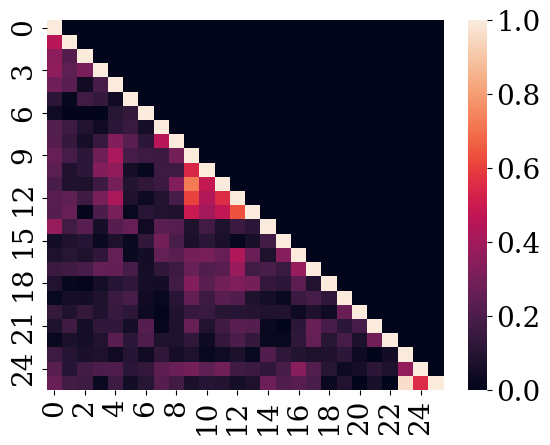

In [80]:
corr = fit_and_plot_DB(attr_emb, emb_per_group)

(2, 23, 768)
explained variance:  [0.10068305 0.072489   0.05644439 0.04223482 0.03989927 0.0337859
 0.03029892 0.02412791 0.02278606 0.02070662]
attr/bios cossim:  0.06866350620975417


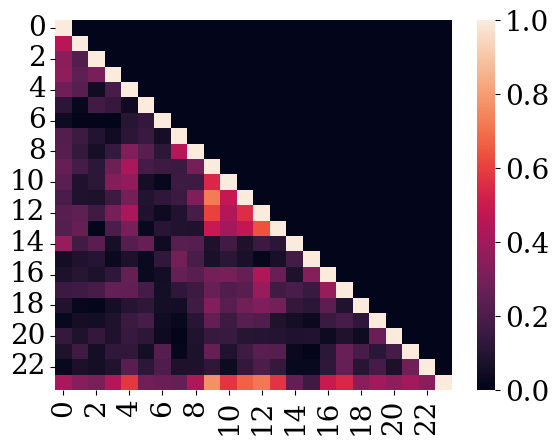

In [81]:
corr2 = fit_and_plot_DB(attr_emb[:,:23,:], emb_per_group, savefile='pca_dir_23.png')

In [82]:
db_diff = (corr[25,:23] - corr2[23,:23])# / corr2[23,:]

## Mean Attribute dir for SAME

In [58]:
def fit_and_plot_SAME(cur_attr_emb, emb_per_group, k=1, savefile='pca_dir.png'):
    print(cur_attr_emb.shape)
    same = SAME()
    same.define_bias_space(cur_attr_emb)
    b_attr = same.pairs[0]
    print(b_attr.shape)

    same.define_bias_space(np.asarray(emb_per_group))
    b_bios = same.pairs[0]
    
    print("attr/bios cossim: ", cossim(b_attr.flatten(), b_bios.flatten()))
    
    n_bias_dir = len(cur_attr_emb[0])+1
    corr = np.eye(n_bias_dir, n_bias_dir)
    for i in range(n_bias_dir-1):
        dir_i = cur_attr_emb[0][i] - cur_attr_emb[1][i]
        for j in range(n_bias_dir-1):
            if j > i:
                continue
            else:
                dir_j = cur_attr_emb[0][j] - cur_attr_emb[1][j]
                corr[i,j] = cossim(dir_i, dir_j)
        corr[-1,i] = cossim(dir_i, b_attr.flatten())
        
        
    sns.heatmap(np.abs(corr))
    plt.savefig(savefile)
    plt.show()
    return corr

(2, 25, 768)
(768,)
attr/bios cossim:  0.4748800941921362


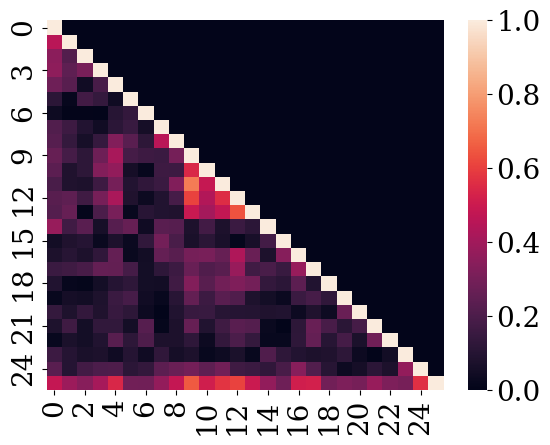

In [59]:
corr = fit_and_plot_SAME(attr_emb, emb_per_group)

(2, 23, 768)
(768,)
attr/bios cossim:  0.4829470997720791


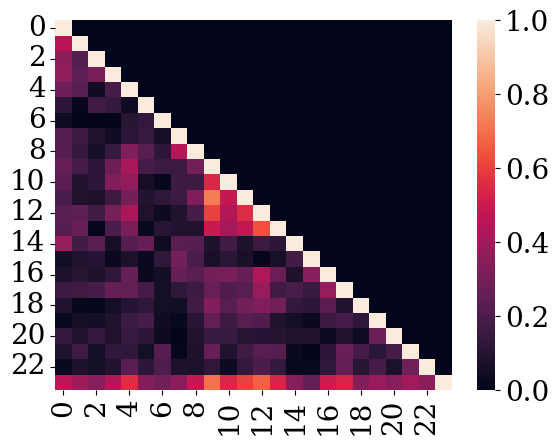

In [60]:
corr2 = fit_and_plot_SAME(attr_emb[:,:23,:], emb_per_group, savefile='pca_dir_23.png')

In [76]:
same_diff = (corr[25,:23] - corr2[23,:23])# / corr2[23,:]

In [77]:
db_diff # cossim-cossim in [-2,2]

array([-0.6841503 , -0.52021865, -0.47542208, -0.47689719, -0.74301438,
       -0.24084531, -0.37263596, -0.48201727, -0.60363118, -0.83780259,
       -0.67400439, -0.76000618, -0.77217972, -0.65172655, -0.53023712,
       -0.37436472, -0.72430639, -0.73986247, -0.3175673 , -0.31672552,
       -0.36357449, -0.47489342, -0.34652763, -1.96646591])

In [78]:
same_diff # cossim-cossim in [-2,2]

array([ 0.01785253, -0.00529326,  0.00344152, -0.03661837, -0.02114639,
       -0.04124136, -0.00372914,  0.02395815, -0.00100324, -0.0504815 ,
       -0.02878885, -0.03294748, -0.06265803, -0.03997976,  0.02805288,
        0.02565088,  0.01359379, -0.01029567, -0.03867483, -0.0606806 ,
       -0.03440453, -0.02559462, -0.03675828])

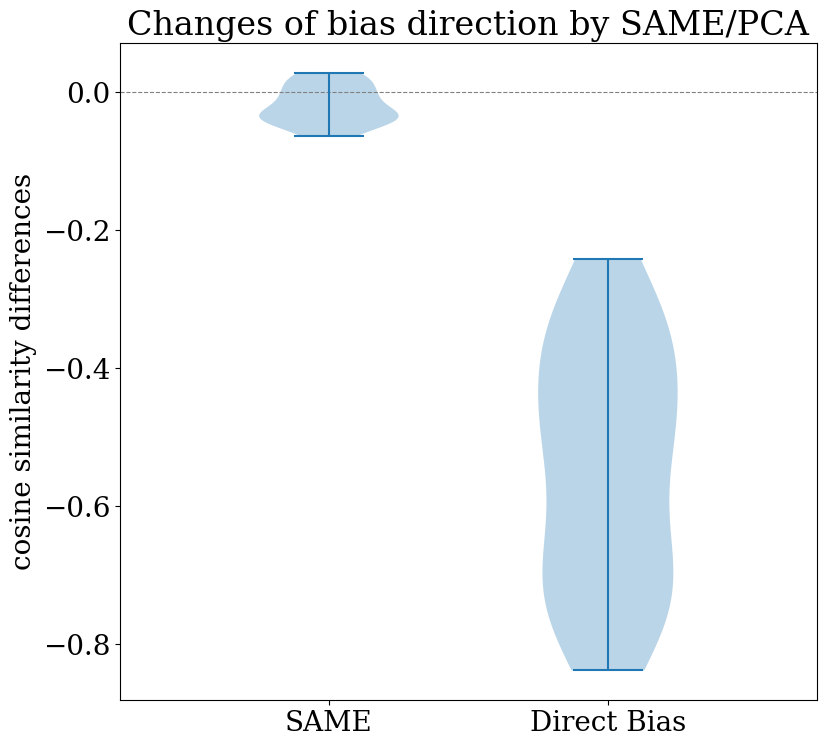

In [83]:
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    #ax.set_xlabel('Sample name')
    ax.hlines(0,0.25, len(labels) + 0.75, 'grey', '--', linewidths=0.8)

labels = ['SAME', 'Direct Bias']
data = [same_diff, db_diff]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 9), sharey=True)

# set style for the axes
set_axis_style(ax, labels)

ax.set_title('Changes of bias direction by SAME/PCA')# of class-wise cosine scores with the TP GAP')
ax.set_ylabel('cosine similarity differences')
ax.violinplot(data)

plt.subplots_adjust(bottom=0.15, wspace=0.05)
#plt.savefig('plots/bios_class_bias.png', bbox_inches="tight")
plt.show()

## SAME subspace alternative

In [66]:
from geometrical_bias import GeometricBias, EmbSetList, EmbSet, normalize, cossim

class SAME2(GeometricBias):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pairs = []

    def attr_mean(self, attribute_set):
        A_unit = normalize(attribute_set)
        center = np.mean(A_unit, axis=0)
        return center

    def attr_pair_diff(self, A, B):
        diff = self.attr_mean(B) - self.attr_mean(A)
        return diff

    def define_bias_space(self, attribute_sets: EmbSetList):
        self.n = len(attribute_sets)
        assert self.n >= 2, "need at least two attribute groups to measure bias!"
        self.A = attribute_sets

        # compute pairwise bias directions in advance
        if self.n == 2:
            self.pairs = [self.attr_pair_diff(attribute_sets[1], attribute_sets[0])]
        else:
            self.mean = np.mean([self.attr_mean(attr_set) for attr_set in attribute_sets])
            self.pairs = []
            for i in range(self.n):
                print(i)
                # remove correlation with previous bias directions (otherwise we might observe the same bias twice)
                # we only need bias directions of pairs (attribute_sets[i], attribute_sets[0]), because others can be
                # written as a linear combination of these
                new_dir = self.attr_mean(attribute_sets[i]) - self.mean
                for dir in self.pairs:
                    dir = dir / np.linalg.norm(dir)
                    corr = np.dot(new_dir, dir)
                    v_corr = corr * dir
                    new_dir = new_dir - v_corr
                    print("\t", corr)
                self.pairs.append(new_dir)

    def pair_bias(self, target, pair_diff):
        return cossim(target, pair_diff)

    def signed_individual_bias(self, target: np.ndarray):
        assert self.n == 2, "signed bias can only be obtained for exactly 2 groups"

        w = target / np.linalg.norm(target)  # need unit vectors!
        return self.pair_bias(w, self.pairs[0])

    def individual_bias(self, target: np.ndarray):
        assert self.n >= 2

        w = target / np.linalg.norm(target)  # need unit vectors!

        # initialize bias with bias to first pair
        bias = abs(self.pair_bias(w, self.pairs[0]))
        if len(self.pairs) == 1:
            return bias

        for i in range(1, len(self.pairs)):
            bias += abs(self.pair_bias(w, self.pairs[i])*np.linalg.norm(self.pairs[i]))

        return bias

    def mean_individual_bias(self, targets: EmbSet):
        return np.mean([self.individual_bias(target) for target in targets])
    
    def individual_bias_per_pair(self, target: np.ndarray):
        assert self.n >= 2

        w = target / np.linalg.norm(target)  # need unit vectors!
        
        biases = []
        biases.append(self.pair_bias(w, self.pairs[0]))
        
        for i in range(1, len(self.pairs)):
            biases.append(self.pair_bias(w, self.pairs[i]))
        return biases

    def individual_bias_pairwise(self, target: np.ndarray, group1: int, group2: int):
        assert (0 <= group1 < self.n and 0 <= group2 < self.n and not group1 == group2)
        pair_diff = self.attr_pair_diff(self.A[group1], self.A[group2])
        return self.pair_bias(target, pair_diff)


In [67]:
same = SAME() # current implementation
same2 = SAME2() # new idea

In [68]:
attributes = [terms_by_groups[group] for group in groups_by_bias_types['religion']]
attr_emb = np.asarray([lm.embed(attr) for attr in attributes])
attr_emb.shape

(5, 14, 768)

In [69]:
same.define_bias_space(attr_emb)
same2.define_bias_space(attr_emb)

0
1
	 0.8097739
2
	 0.76104677
	 0.1550313
3
	 0.7840803
	 0.14713308
	 0.09202547
4
	 0.7237799
	 0.19498035
	 0.061509833
	 0.15937296


In [52]:
np.asarray(same.pairs).shape

(4, 768)

In [53]:
np.asarray(same2.pairs).shape

(5, 768)

In [54]:
corr = np.sum([cossim(same.pairs[i], same2.pairs[j]) for i in range(len(same.pairs)) for j in range(len(same2.pairs))])
corr

-2.9358794854459247

In [55]:
[[cossim(same.pairs[i], same2.pairs[j]) for i in range(len(same.pairs))] for j in range(len(same2.pairs))]

[[0.16790237351399434,
  0.2675466803466656,
  0.0936061535650019,
  0.23057413391295675],
 [-0.9858036465574054,
  0.045568677777714964,
  0.015943038531920452,
  0.03927148267731656],
 [1.7658582772281805e-08,
  -0.9624666979630607,
  0.026775497896320787,
  0.06595445084578903],
 [6.862620802065528e-08,
  8.2338114074835e-08,
  -0.9951214429108356,
  0.0240927819561966],
 [-4.1508745975153734e-08,
  -2.1990683163376585e-08,
  -1.3860632642045916e-08,
  -0.9697230603013434]]

In [56]:
np.linalg.norm(same2.pairs, axis=1)

array([0.87065834, 0.35747045, 0.29088718, 0.3368239 , 0.2977704 ],
      dtype=float32)

In [57]:
np.linalg.norm(same.pairs, axis=1)

array([0.3626183 , 0.30223086, 0.33847517, 0.30706745], dtype=float32)

## WEAT magntiude comparability

Train BERT on raw/ neutralized texts -> we expect less bias in the latter version (verify with GAP).

In [17]:
def gap_score_one_hot(y_pred: np.ndarray, y_true: np.ndarray, groups: np.ndarray):
    assert len(y_pred.shape) == 2
    assert y_pred.shape == y_true.shape
    n_groups = np.max(groups)+1
    n_samples = y_pred.shape[0]
    n_classes = y_pred.shape[1]
    
    gaps = []
    for c in range(n_classes):
        y_pred_c = y_pred[:,c]
        y_true_c = y_true[:,c]
        
        group_tp = []
        for g in range(n_groups):
            y_pred_cg = [y_pred_c[i] for i in range(n_samples) if groups[i] == g]
            y_true_cg = [y_true_c[i] for i in range(n_samples) if groups[i] == g]
            tp = len([1 for i in range(len(y_pred_cg)) if y_true_cg[i] == 1 and y_pred_cg[i] == 1])/np.sum(y_true_cg)
            group_tp.append(tp)
        
        if n_groups == 2:
            gaps.append(group_tp[0]-group_tp[1])
        else:
            gaps.append(np.var(group_tp))
    return gaps

In [18]:
fold_id = 0
bios_dataset.set_data_split(fold_id)

In [19]:
def count_groups_per_label(y, groups, return_dict=False):
    assert len(y) == len(groups)
    n_groups = max(groups)+1
    n_classes = y.shape[1]
    lookup = {lbl: {group: 0 for group in range(n_groups)} for lbl in range(n_classes)}
    for i in range(len(y)):
        for idx in np.where(y[i] == 1)[0]:
            lookup[idx][groups[i]] += 1
        
    if return_dict:
        return lookup
    
    df = pd.DataFrame(data=lookup)
    return df
            

def resample(X, y, groups):
    df = count_groups_per_label(y,groups)
    print(df)
    
    n_per_group_class = int(np.mean(df))
    print(n_per_group_class)
    
    n_groups = max(groups)+1
    n_classes = y.shape[1]
    n_samples = len(X)
    
    new_X = []
    new_y = []
    new_g = []
    for c in range(n_classes):
        for group in range(n_groups):
            X_cg = [X[i] for i in range(n_samples) if y[i][c] == 1 and groups[i] == group]
            y_cg = [y[i] for i in range(n_samples) if y[i][c] == 1 and groups[i] == group]
            g_cg = [groups[i] for i in range(n_samples) if y[i][c] == 1 and groups[i] == group]
            for i in range(n_per_group_class):
                idx = random.choice(range(len(X_cg)))
                new_X.append(X_cg[idx])
                new_y.append(y_cg[idx])
                new_g.append(g_cg[idx])
             
    print("after resample")
    new_y = np.asarray(new_y)
    df = count_groups_per_label(new_y, new_g)
    print(df)
    
    new_X, new_y = shuffle(new_X, new_y)
    return new_X, new_y

In [29]:
majority_factor = [1.2, 1.2]

def get_classes_by_majority_group(y_train, groups_train):
    sample_dist = count_groups_per_label(y_train, groups_train)
    samples0 = np.sum([sample_dist[job][0] for job in sample_dist.keys()])
    samples1 = np.sum([sample_dist[job][1] for job in sample_dist.keys()])
    
    # partitioning for WEAT
    classes_by_majority_group = {0: [], 1: []}
    for job, dist in sample_dist.items():
        #rel_num0 = dist[0]/samples0
        #rel_num1 = dist[1]/samples1
        #if rel_num0 > majority_factor[0]*rel_num1:
        #    classes_by_majority_group[0].append(job)
        #elif rel_num1 > majority_factor[1]*rel_num0:
        #    classes_by_majority_group[1].append(job)
        if dist[0] > majority_factor[0]*dist[1]:
            classes_by_majority_group[0].append(job)
        elif dist[1] > majority_factor[1]*dist[0]:
            classes_by_majority_group[1].append(job)

    print("classes per majority group: ")
    print(classes_by_majority_group)
    
    return classes_by_majority_group

PUNCTUATION = string.punctuation.replace('-','')
def simplify_text(text: str):
    return text.strip().lower().translate(str.maketrans('', '', PUNCTUATION))

In [30]:
titles_raw = [simplify_text(title) for title in titles]
print(titles_raw)

['architect', 'psychologist', 'professor', 'photographer', 'journalist', 'attorney', 'teacher', 'dentist', 'software architect', 'writer', 'surgeon', 'physician', 'nurse', 'researcher']


In [31]:
y_train = np.asarray([sample['label'] for sample in bios_dataset.train_data])
groups = [sample['group'] for sample in bios_dataset.train_data]

n_classes = len(titles)
n_groups = 2
mean_n_samples = len(bios_dataset.train_data)/(n_classes*n_groups) # per class
sample_dist = {title: {'male': 0, 'female': 0} for title in bios_dataset.labels}
for sample in bios_dataset.train_data:
    for i in range(sample['label'].shape[0]):
        if sample['label'][i] == 1:
            sample_dist[bios_dataset.labels[i]][bios_dataset.sel_groups[sample['group']]] += 1

df = pd.DataFrame(sample_dist)
print("train data stats for fold ", fold_id)
print(df)
class_gender_weights = {g: {lbl: mean_n_samples/df.loc[g,lbl] for lbl in bios_dataset.labels} for g in bios_dataset.sel_groups}
# for each class: number of negative samples over number of positive samples -> pos weight
class_weights = [(len(bios_dataset.train_data)-np.sum(df.loc[:,lbl]))/np.sum(df.loc[:,lbl]) for lbl in bios_dataset.labels]
print("class weights: ", class_weights)

classes_by_majority_group = get_classes_by_majority_group(y_train, groups)
print("classes by majority group: ", classes_by_majority_group)

train data stats for fold  0
        architect  psychologist  professor  photographer  journalist  \
male          215           322        211           954         760   
female         74           469        178           465         725   

        attorney  teacher  dentist  *software architect  *writer  surgeon  \
male         723      434       82                  140      356      766   
female       437      609       46                   14      371       97   

        physician  nurse  *researcher  
male          629     39          152  
female        353    481           69  
class weights:  [29.134948096885815, 10.010113780025284, 21.388174807197945, 5.137420718816068, 4.864646464646465, 6.507758620689655, 7.349952061361457, 67.0390625, 55.55194805194805, 10.979367262723521, 9.09154113557358, 7.868635437881874, 15.748076923076923, 38.40723981900452]
classes per majority group: 
{0: [0, 3, 5, 7, 8, 10, 11, 13], 1: [1, 6, 12]}
classes by majority group:  {0: [0, 3, 5, 7, 

In [32]:
def plot_violin(target_bias, classes_by_majority_group, title, xlabel, save=None):
    labels = ['stereo male', 'stereo female']
    fig, ax = plt.subplots()
    data = [[target_bias[i] for i in classes_by_majority_group[g]] for g in [0,1]]
    ax.vlines(0,0.25, len(labels) + 0.75, 'grey', '--', linewidths=0.8)
    ax.violinplot(data, vert=False)
    ax.set_xlabel(xlabel)
    ax.set_yticks(np.arange(1, len(data) + 1), labels=labels)
    xmax = np.max(np.abs(ax.get_xlim()))
    ax.set_xlim(-xmax, xmax)
    ax.set_title(title)
    plt.tight_layout()
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
    plt.show()

In [33]:
bios_dataset.sel_groups

['male', 'female']

In [34]:
## attribute diff
def test_attribute_emb(model_name):
    batch_size = 8
    if 'gpt' in model_name:
        batch_size = 1
    lm = BertHuggingface(model_name=model_name, batch_size=batch_size, num_labels=2)
    attr_emb = [lm.embed(attr) for attr in attributes]
    attr_len = 0.5*(np.mean(np.linalg.norm(attr_emb[0], axis=1))+np.mean(np.linalg.norm(attr_emb[1], axis=1)))
    #sample_len = np.mean(np.linalg.norm(target_emb_all, axis=1))
    attr_diff = [np.asarray(attr_emb[0])-np.asarray(attr_emb[1])]
    mean_attr_diff = np.mean(np.linalg.norm(attr_diff, axis=1))

    return attr_len, mean_attr_diff

models = ['openai-gpt', 'gpt2', 'GroNLP/hateBERT', 'bert-large-uncased', 'bert-base-uncased', 'bert-large-uncased', 'distilbert-base-uncased', 'roberta-base', 
          'distilroberta-base', 'bert-large-uncased-whole-word-masking', 'google/electra-base-generator', 'albert-base-v2', 'xlnet-base-cased']
res = {'attr_len': {}, 'attr_diff': {}}
for model in models:
    attr_len, mean_attr_diff = test_attribute_emb(model)
    res['attr_len'][model] = attr_len
    res['attr_diff'][model] = mean_attr_diff
df = pd.DataFrame(data=res)
df

Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using pad_token, but it is not set yet.


Using Bert with CUDA/GPU


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using pad_token, but it is not set yet.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased-whole-word-masking and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-generator and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.bias', 'logits_proj.weight', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Using Bert with CUDA/GPU


,attr_len,attr_diff
openai-gpt,12.297695,0.727554
gpt2,92.566010,0.842266
GroNLP/hateBERT,9.891623,0.949508
bert-large-uncased,13.982952,1.123194
bert-base-uncased,8.870662,0.567524
distilbert-base-uncased,8.352082,0.433000
roberta-base,10.950018,0.234675
distilroberta-base,13.376940,0.197752
bert-large-uncased-whole-word-masking,16.082153,1.631738
google/electra-base-generator,6.333381,0.517917


In [35]:
def evaluate_model_bias(model_name, save_fig=False, targets=None, targets_by_group=None):
    print("###########################################")
    print("###### Evaluate "+model_name+" ############")
    print("###########################################")
    batch_size = 8
    if 'gpt' in model_name:
        batch_size = 1
    lm = BertHuggingface(model_name=model_name, batch_size=batch_size, num_labels=2) #roberta-base , distilbert-base-uncased
    emb_size = lm.model.config.hidden_size

    attr_emb = [lm.embed(attr) for attr in attributes]
    target_emb_all = lm.embed([sample['text'] for sample in bios_dataset.sel_data])
    title_emb = lm.embed(titles_raw)
    
    print("mean len of attribute emb: ", 0.5*(np.mean(np.linalg.norm(attr_emb[0], axis=1))+np.mean(np.linalg.norm(attr_emb[1], axis=1))))
    print("mean len of sample emb: ", np.mean(np.linalg.norm(target_emb_all, axis=1)))
    attr_diff = [np.asarray(attr_emb[0])-np.asarray(attr_emb[1])]
    print("mean attr diff: ", np.mean(np.linalg.norm(attr_diff, axis=1)))

    train_ids = [sample['id'] for sample in bios_dataset.train_data]
    emb_train = np.asarray([target_emb_all[i] for i in train_ids])
    y_train = np.asarray([sample['label'] for sample in bios_dataset.train_data])
    groups = [sample['group'] for sample in bios_dataset.train_data]

    test_ids = [sample['id'] for sample in bios_dataset.eval_data]
    emb_test = np.asarray([target_emb_all[i] for i in test_ids])
    y_test = np.asarray([sample['label'] for sample in bios_dataset.eval_data])
    groups_test = [sample['group'] for sample in bios_dataset.eval_data]
    
    parameters = {'optimizer': 'RMSprop', 'criterion': 'BCEWithLogitsLoss', 'lr': 1e-4, 'epochs': 5, 'batch_size': 8}
    head = SimpleCLFHead(input_size=emb_size, output_size=len(titles))#, hidden_size=emb_size)
    clf = CustomModel(parameters, head, class_weights=class_weights)
    clf.set_lr(parameters['lr'])
    clf.fit(emb_train, y_train, epochs=parameters['epochs'])#, weights=w_train)
    pred = clf.predict(emb_test)
    y_pred = (np.array(pred) >= 0.5).astype(int)
    score = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print("f1:", score)
    print("recall:", recall)
    gaps = gap_score_one_hot(y_pred, y_test, groups_test)
    print("gaps: ", gaps)
    print("mean gap: ", np.mean(np.abs(gaps)))

    weat = WEAT()
    weat.define_bias_space(attr_emb)
    weat_scores = [weat.individual_bias(e) for e in emb_test]

    weat_word = [weat.individual_bias(te) for te in title_emb]
    print("titles WEAT scores: ", weat_word)

    max_emb = min([groups_test.count(i) for i in [0,1]])
    emb_per_group = [[emb_test[i] for i in range(len(emb_test)) if groups_test[i] == group][:max_emb] for group in range(max(groups_test)+1)]

    target_emb_per_group = []
    for group in range(max(groups_test)+1):
        group_emb = []
        for i in range(len(y_test)):
            for lbl in classes_by_majority_group[group]:
                if y_test[i][lbl] == 1:
                    group_emb.append(emb_test[i])
        target_emb_per_group.append(group_emb)
    eff_size = weat.group_bias(target_emb_per_group)
    print("effect size: ", eff_size)

    print("titles used: ", [[titles_raw[i] for i in classes_by_majority_group[g]] for g in classes_by_majority_group.keys()])
    titles_per_group = [[titles[i] for i in classes_by_majority_group[g]] for g in classes_by_majority_group.keys()]
    title_emb_per_group = [lm.embed(group_titles) for group_titles in titles_per_group]
    eff_word = weat.group_bias(title_emb_per_group)
    print("effect size (titles): ", eff_word)
    
    if save_fig:
        plot_violin(weat_word, classes_by_majority_group, title='WEAT sample bias (Effect Size: %0.2f)' % (eff_word), xlabel='s(t,A,B)', save=model_name+"_weat.png")
        plot_violin(gaps, classes_by_majority_group, title='GAP scores', xlabel='GAP_c', save=model_name+"_gaps.png")
    else:
        plot_violin(weat_word, classes_by_majority_group, title='WEAT sample bias (Effect Size: %0.2f)' % eff_word, xlabel='s(t,A,B)')
        plot_violin(gaps, classes_by_majority_group, title='GAP scores', xlabel='GAP_c')
    
    #fig, ax = plt.subplots(2, 1, figsize=(10,5))
    #ax[0].hist(weat_scores)
    #ax[0].set_title('BIOS emb, GAP: %0.2f (+/- %0.3f), Effect Size: %0.2f' % (np.mean(np.abs(gaps)), np.std(np.abs(gaps)), eff_size))
    
    #ax[1].hist(weat_word)
    #ax[1].set_title('Title emb, GAP: %0.2f (+/- %0.3f), Effect Size: %0.2f' % (np.mean(np.abs(gaps)), np.std(np.abs(gaps)), eff_word))
    #plt.show()
    print()

###########################################
###### Evaluate openai-gpt ############
###########################################


Some weights of OpenAIGPTForSequenceClassification were not initialized from the model checkpoint at openai-gpt and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using pad_token, but it is not set yet.


Using Bert with CUDA/GPU
mean len of attribute emb:  12.29769515991211
mean len of sample emb:  10.907939
mean attr diff:  0.72755355
use class weights
f1: 0.6290998986876922
recall: 0.7679492264974217
gaps:  [0.36538461538461536, -0.19365079365079363, 0.04019607843137252, 0.08473797119215443, 0.0019829164124466336, 0.029021151008362, -0.3081064356435644, 0.23636363636363633, 0.26881720430107525, 0.056017885976897386, 0.19851036269430056, 0.2067019400352733, -0.5272727272727273, 0.4120879120879121]
mean gap:  0.2092036878896522
titles WEAT scores:  [-0.015554504473408226, -0.01714719595667824, -0.008370683365879095, -0.020569082181082776, -0.016536669460530784, -0.017452822025632142, -0.01670047751313075, -0.014916671201137599, -0.017057684794624217, -0.016684529469257248, -0.019833842198289542, -0.017995767635740623, -0.017809769190170188, -0.017476514874127935]


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.


effect size:  -0.2879504389571458
titles used:  [['architect', 'photographer', 'attorney', 'dentist', 'software architect', 'surgeon', 'physician', 'researcher'], ['psychologist', 'teacher', 'nurse']]
effect size (titles):  0.489007869461094


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

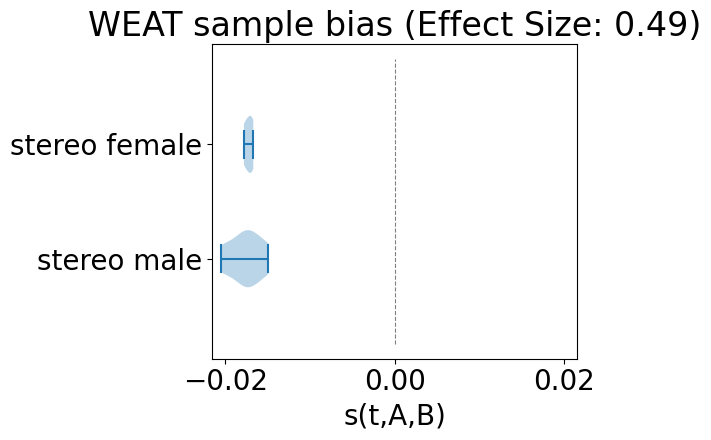

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

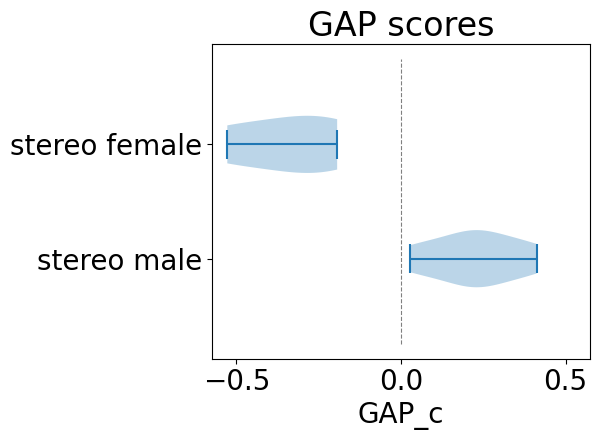

In [36]:
evaluate_model_bias('openai-gpt', save_fig=True)

###########################################
###### Evaluate distilbert-base-uncased ############
###########################################


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Bert with CUDA/GPU
mean len of attribute emb:  8.352082252502441
mean len of sample emb:  7.769624
mean attr diff:  0.43300036
use class weights
f1: 0.6732871022454743
recall: 0.781832606108687
gaps:  [0.32692307692307687, -0.08412698412698416, -0.0186274509803922, 0.05136377566656447, 0.02016473459426482, 0.1353773842706455, -0.3430074257425743, 0.2121212121212121, 0.6666666666666667, 0.07141969941622162, 0.16709844559585496, 0.1775132275132275, -0.6768595041322314, 0.2692307692307693]
mean gap:  0.23003573978433473
titles WEAT scores:  [-0.00653561306715067, -0.009555711112810283, -0.0002603488765142714, -0.007064083316033143, -0.009188063354254039, -0.004489652867020522, -0.008500300401675376, -0.004019713057197061, -0.006525500572557963, -0.009850854536581188, -0.003568718025735329, -0.007109543060037415, -0.01673047630256863, -0.009087198003009278]


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

effect size:  0.7465986102655794
titles used:  [['architect', 'photographer', 'attorney', 'dentist', 'software architect', 'surgeon', 'physician', 'researcher'], ['psychologist', 'teacher', 'nurse']]
effect size (titles):  1.6607770481415962


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

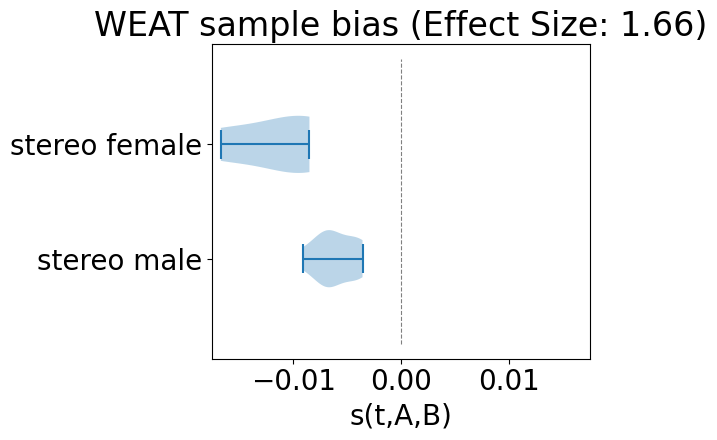

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

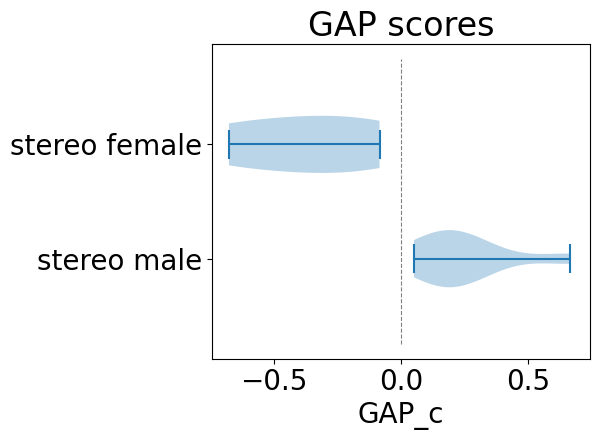

In [37]:
evaluate_model_bias('distilbert-base-uncased', save_fig=True)

In [ ]:
# other models
evaluate_model_bias('gpt2', save_fig=True)
evaluate_model_bias('GroNLP/hateBERT')
evaluate_model_bias('bert-base-uncased')
evaluate_model_bias('bert-base-cased')
evaluate_model_bias('bert-large-cased')
evaluate_model_bias('bert-large-uncased-whole-word-masking')
evaluate_model_bias('bert-large-uncased')
evaluate_model_bias('roberta-base')
evaluate_model_bias('xlnet-base-cased')
evaluate_model_bias('distilroberta-base')
evaluate_model_bias('google/electra-base-generator')
evaluate_model_bias('albert-base-v2')